In [1]:
!pip install tushare

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [35]:
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123) # 使得每次运行得到的随机数都一样

In [3]:
# 使用tushare来获取股票数据
import tushare as ts
def get_K_dataframe(code,start,end):
    pro = ts.pro_api('f98c3f069d12208b7e58cbdd54f37434c6b6477f6d4f1f8d2553c04f')
    df = pro.daily(**{
        "ts_code": code,
        "trade_date": "",
        "start_date": start,
        "end_date": end,
        "offset": "",
        "limit": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "high",
        "low",
        "close",
        "pre_close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    return df

In [4]:
def get_batch_K_df(codes_list,start,end):
    df=pd.DataFrame()
    print('fetching data. pls wait...')
    for code in codes_list:
        df=df.append(get_K_dataframe(code,start,end))
    return df

In [5]:
# 数据规整函数，用于对获取的df进行数据处理
def preprocess_data(stock_df,min_K_num=1000):
    df=stock_df.copy()
    df['diff']=df.close - df.open  # 此处用收盘价与开盘价的差值做分析
    df.drop(['open','close','high','low'],axis=1,inplace=True)
    
    result_df=None 
    #下面一部分是将不同的股票diff数据整合为不同的列，列名为股票代码
    for name, group in df[['trade_date','diff']].groupby(df.ts_code):
        if len(group.index)<min_K_num: continue
        if result_df is None:
            result_df=group.rename(columns={'diff':name})
        else:
            result_df=pd.merge(result_df,
                                group.rename(columns={'diff':name}),
                                on='trade_date',how='inner') # 一定要inner，要不然会有很多日期由于股票停牌没数据
    
    result_df.drop(['trade_date'],axis=1,inplace=True)
    # 然后将股票数据DataFrame转变为np.ndarray
    stock_dataset=np.array(result_df).astype(np.float64)
    # 数据归一化，此处使用相关性而不是协方差的原因是在结构恢复时更高效
    stock_dataset/=np.std(stock_dataset,axis=0)
    return stock_dataset,result_df.columns.tolist()

In [6]:
sz50_df = pd.read_excel("C:/Users/EdmundLee/Desktop/上证50指数成份.xlsx.xlsx")
stock_list = sz50_df['代码'].tolist()
print(stock_list)
batch_K_data = get_batch_K_df(stock_list,start='2017-04-13',end='2022-04-13') # 查看最近五年的数据
print(batch_K_data.info())

['600000.SH', '600010.SH', '600015.SH', '600016.SH', '600018.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH', '600048.SH', '600050.SH', '600104.SH', '600111.SH', '600256.SH', '600332.SH', '600362.SH', '600383.SH', '600406.SH', '600489.SH', '600518.SH', '600519.SH', '600547.SH', '600549.SH', '600585.SH', '600637.SH', '600837.SH', '600887.SH', '600999.SH', '601006.SH', '601088.SH', '601117.SH', '601166.SH', '601169.SH', '601288.SH', '601299.SH', '601318.SH', '601328.SH', '601336.SH', '601398.SH', '601601.SH', '601628.SH', '601668.SH', '601688.SH', '601699.SH', '601766.SH', '601818.SH', '601857.SH', '601899.SH', '601901.SH', '601989.SH']
fetching data. pls wait...


C:\Users\EdmundLee\AppData\Local\Temp\ipykernel_13104\2820336931.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(get_K_dataframe(code,start,end))
C:\Users\EdmundLee\AppData\Local\Temp\ipykernel_13104\2820336931.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(get_K_dataframe(code,start,end))
C:\Users\EdmundLee\AppData\Local\Temp\ipykernel_13104\2820336931.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(get_K_dataframe(code,start,end))
C:\Users\EdmundLee\AppData\Local\Temp\ipykernel_13104\2820336931.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(get_K_dataframe(code,star

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59056 entries, 0 to 1102
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ts_code     59056 non-null  object
 1   trade_date  59056 non-null  object
 2   open        59056 non-null  object
 3   high        59056 non-null  object
 4   low         59056 non-null  object
 5   close       59056 non-null  object
 6   pre_close   59056 non-null  object
 7   change      59056 non-null  object
 8   pct_chg     59056 non-null  object
 9   vol         59056 non-null  object
 10  amount      59056 non-null  object
dtypes: object(11)
memory usage: 5.4+ MB
None


In [7]:
print(batch_K_data)

        ts_code trade_date  open  high   low close pre_close change pct_chg  \
0     600000.SH   20211231  8.54  8.57  8.53  8.53      8.54  -0.01 -0.1171   
1     600000.SH   20211230  8.54  8.58  8.53  8.54      8.54    0.0     0.0   
2     600000.SH   20211229  8.57  8.58  8.53  8.54      8.57  -0.03 -0.3501   
3     600000.SH   20211228  8.56  8.59  8.54  8.57      8.56   0.01  0.1168   
4     600000.SH   20211227  8.54  8.57  8.53  8.56      8.54   0.02  0.2342   
...         ...        ...   ...   ...   ...   ...       ...    ...     ...   
1098  601989.SH   20170109  7.43   7.8   7.4  7.76      7.44   0.32     4.3   
1099  601989.SH   20170106  7.47  7.57  7.39  7.44      7.48  -0.04   -0.53   
1100  601989.SH   20170105  7.34  7.52  7.34  7.48      7.37   0.11    1.49   
1101  601989.SH   20170104   7.3  7.41   7.3  7.37      7.34   0.03    0.41   
1102  601989.SH   20170103  7.12  7.36  7.11  7.34      7.09   0.25    3.53   

             vol       amount  
0      229296.21   

In [8]:
stock_dataset,selected_stocks=preprocess_data(batch_K_data,min_K_num=1100)
print(stock_dataset.shape)  # (882, 49) 由此可以看出得到了882个交易日的数据，其中有49只股票被选出。
# 其他的1只股票因为不满足最小交易日的要求而被删除。这882个交易日是所有49只股票都在交易，都没有停牌的数据。
print(selected_stocks) # 这是实际使用的股票列表

(882, 49)
['600000.SH', '600010.SH', '600015.SH', '600016.SH', '600018.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH', '600048.SH', '600050.SH', '600104.SH', '600111.SH', '600256.SH', '600332.SH', '600362.SH', '600383.SH', '600406.SH', '600489.SH', '600518.SH', '600519.SH', '600547.SH', '600549.SH', '600585.SH', '600637.SH', '600837.SH', '600887.SH', '600999.SH', '601006.SH', '601088.SH', '601117.SH', '601166.SH', '601169.SH', '601288.SH', '601318.SH', '601328.SH', '601336.SH', '601398.SH', '601601.SH', '601628.SH', '601668.SH', '601688.SH', '601699.SH', '601766.SH', '601818.SH', '601857.SH', '601899.SH', '601901.SH', '601989.SH']


In [9]:
print(stock_dataset)

[[-0.07960319  0.73140728  0.13110547 ...  0.18875901 -0.17779678
   0.11831594]
 [ 0.         -0.36570364 -0.13110547 ... -0.06291967  0.29632796
   0.35494782]
 [-0.23880956 -0.9142591   0.13110547 ... -0.50335737 -0.17779678
   0.        ]
 ...
 [ 2.54730196 -0.54855546  2.09768758 ...  0.25167869 -0.35559355
  -0.70989564]
 [ 0.15920637  0.18285182  0.13110547 ... -0.12583934 -0.41485914
   0.94652752]
 [-0.07960319  0.73140728  0.5244219  ...  1.69883113  0.77045269
  -0.11831594]]


In [10]:
# 从相关性中学习其图形结构
from sklearn.covariance import GraphicalLassoCV
edge_model=GraphicalLassoCV()
edge_model.fit(stock_dataset)

E:\Users\EdmundLee\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV()

In [11]:
# 使用近邻传播算法构建模型，并训练LassoCV graph
from sklearn.cluster import affinity_propagation
_,labels=affinity_propagation(edge_model.covariance_)

In [12]:
n_labels=max(labels) 
# 对这49只股票进行了聚类，labels里面是每只股票对应的类别标号
print('Stock Clusters: {}'.format(n_labels+1)) # 10，即得到10个类别
sz50_df2=sz50_df.set_index('代码')
# print(sz50_df2)
for i in range(n_labels+1):
    # print('Cluster: {}----> stocks: {}'.format(i,','.join(np.array(selected_stocks)[labels==i]))) # 这个只有股票代码而不是股票名称
    # 下面打印出股票名称，便于观察
    stocks=np.array(selected_stocks)[labels==i].tolist()
    names=sz50_df2.loc[stocks,:].name.tolist()
    print('Cluster: {}----> stocks: {}'.format(i,','.join(names)))

Stock Clusters: 11
Cluster: 0----> stocks: 浦发银行,华夏银行,民生银行,招商银行,中国联通,大秦铁路,兴业银行,北京银行,农业银行,交通银行,工商银行,中国建筑,中国南车,光大银行
Cluster: 1----> stocks: 上港集团,中信证券,上汽集团,百视通,海通证券,招商证券,华泰证券,方正证券,中国重工
Cluster: 2----> stocks: 保利地产,金地集团,海螺水泥
Cluster: 3----> stocks: 包钢股份,包钢稀土,厦门钨业
Cluster: 4----> stocks: 江西铜业,紫金矿业
Cluster: 5----> stocks: 国电南瑞
Cluster: 6----> stocks: 中金黄金,山东黄金
Cluster: 7----> stocks: 白云山,康美药业
Cluster: 8----> stocks: 三一重工,贵州茅台,伊利股份
Cluster: 9----> stocks: 中国石化,广汇能源,中国神华,中国化学,潞安环能,中国石油
Cluster: 10----> stocks: 中国平安,新华保险,中国太保,中国人寿


In [13]:
from sklearn import manifold
from matplotlib.collections import LineCollection

# 对这些结果进行可视化
def visual_stock_relationship(dataset,edge_model,labels,stock_names):
    node_position_model = manifold.LocallyLinearEmbedding(
        n_components=2, eigen_solver='dense', n_neighbors=6)

    embedding = node_position_model.fit_transform(dataset.T).T
    
    plt.figure(1, facecolor='w', figsize=(10, 8))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Display a graph of the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
                cmap=plt.cm.nipy_spectral)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r,
                        norm=plt.Normalize(0, .7 * values.max()))
    lc.set_array(values)
    lc.set_linewidths(15 * values)
    ax.add_collection(lc)

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    n_labels=max(labels) 
    for index, (name, label, (x, y)) in enumerate(
            zip(stock_names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .001
        else:
            horizontalalignment = 'right'
            x = x - .001
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .001
        else:
            verticalalignment = 'top'
            y = y - .001
        plt.text(x, y, name, size=10,fontproperties = 'SimHei',
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())

    plt.show()

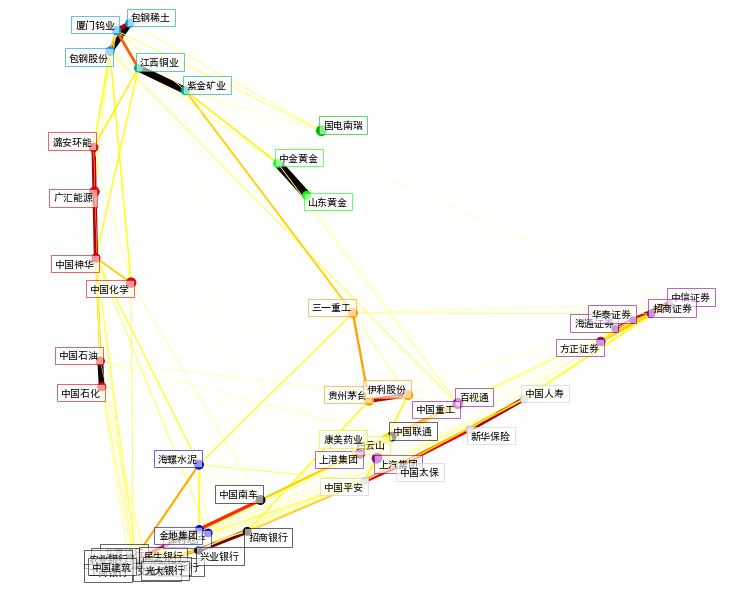

In [14]:
stock_names=sz50_df2.loc[selected_stocks,:].name.tolist()
visual_stock_relationship(stock_dataset,edge_model,labels,stock_names)